In [109]:
import os
import time
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

import seaborn as sns
import allocation
import utils as hrp_utils

In [189]:
import importlib
importlib.reload(allocation)
importlib.reload(hrp_utils)

<module 'utils' from '/Users/vdp/projects/hierarchical_risk_parity/utils.py'>

In [111]:
# directory information
CUR_DIR = os.getcwd()
DATA_FOLDER = os.path.join(CUR_DIR, "data")
ALL_DATA = os.path.join(DATA_FOLDER, "dataset.feather")
SNP_CONSTITUENTS = os.path.join(DATA_FOLDER, "snp_constituents.json")

## Loading Data

#### NOTE: SNP Constituents are calculated at the start of the each year and remain the same for entire year

In [96]:
df = pd.read_feather(ALL_DATA)
df.head()

,date,ticker,permno,ret,mkt_cap,shrout,prc,year
0,2000-01-03,ROK,84381,0.031332,9392211.250,190222.0,49.3750,2000
1,2000-01-04,ROK,84381,-0.036709,9047433.875,190222.0,47.5625,2000
2,2000-01-05,ROK,84381,0.005256,9094989.375,190222.0,47.8125,2000
3,2000-01-06,ROK,84381,-0.016993,8940434.000,190222.0,47.0000,2000
4,2000-01-07,ROK,84381,0.027926,9190100.375,190222.0,48.3125,2000


In [61]:
# getting snp contituents for each year
with open(SNP_CONSTITUENTS) as f:
    snp_constituents = json.load(f)

len(snp_constituents["2021"])

501

### Filtering for returns data

In [154]:
data_df = df[["date", "permno", "ret", "year", "mkt_cap"]]
data_df.head()

,date,permno,ret,year,mkt_cap
0,2000-01-03,84381,0.031332,2000,9392211.250
1,2000-01-04,84381,-0.036709,2000,9047433.875
2,2000-01-05,84381,0.005256,2000,9094989.375
3,2000-01-06,84381,-0.016993,2000,8940434.000
4,2000-01-07,84381,0.027926,2000,9190100.375


### Cleaning the dataset for each year

In [155]:
data_df = data_df.groupby("year").apply(lambda x: hrp_utils.clean_dataset(x)).reset_index(drop=True)
data_df.head()

,date,permno,ret,year,mkt_cap
0,2000-01-03,84381,0.031332,2000,9392211.250
1,2000-01-04,84381,-0.036709,2000,9047433.875
2,2000-01-05,84381,0.005256,2000,9094989.375
3,2000-01-06,84381,-0.016993,2000,8940434.000
4,2000-01-07,84381,0.027926,2000,9190100.375


## Bases Cases: 
    1. Market weighted returns
    2. Equal weighted returns

In [207]:
# deriving weights for base cases
mkt_df = data_df.drop_duplicates(subset=["year", "permno"], keep="last")[["year", "permno", "mkt_cap"]].reset_index(drop=True)
mkt_df["lag_mkt_cap"] =  mkt_df.groupby(["permno"])["mkt_cap"].shift()
mkt_df = mkt_df.dropna().reset_index(drop=True)

In [208]:
# using compute functions form allocation library/ to get market and equal weights
mkt_wgt_df = mkt_df.groupby("year").apply(lambda x: allocation.compute_mkt_weights(x)).reset_index()
eq_wgt_df = mkt_df.groupby("year").apply(lambda x: allocation.compute_unif_weights(x)).reset_index()

In [206]:
base_df = data_df.merge(mkt_wgt_df, on=["year", "permno"], how="left")
base_df = base_df[base_df["year"] > 2000]

base_df = base_df.merge(eq_wgt_df, on=["year", "permno"], how="left")
base_df["MKT_wgt_ret"] = base_df["ret"] * base_df["MKT"]
base_df["EQ_wgt_ret"] = base_df["ret"] * base_df["EQ"]

# daily returns of the portfolio
base_ret_df = base_df.groupby("date")["MKT_wgt_ret", "EQ_wgt_ret"].sum()

In [199]:
base_ret_df

,MKT_wgt_ret,EQ_wgt_ret
date,,
2001-01-02,-0.028877,-0.028219
2001-01-03,0.055665,0.046295
2001-01-04,-0.012854,-0.009114
2001-01-05,-0.025212,-0.020683
2001-01-08,-0.001344,0.002724
...,...,...
2022-12-23,0.004794,0.006778
2022-12-27,-0.007404,0.000080
2022-12-28,-0.011456,-0.013615


## HRP Performance with Different Linkages

In [118]:
linkage_types = ["single", "complete", "ward", "average"]

### Splitting dataset by year, getting weights based on previous year correlations, measuring weighted returns for current year 

In [143]:
%%time
test_df_lst = list()

for year in range(2001, 2023):
    test_df = data_df[data_df["year"] == year].set_index("permno")
    stocks = test_df.index
    
    form_df = data_df[data_df["year"] == (year - 1)]
    form_df = form_df[form_df["permno"].isin(stocks)]
    
    weights_list = list()
    for linkage_type in linkage_types:
        weight_df = allocation.compute_hrp_weights(df=form_df, linkage_type=linkage_type).to_frame()
        test_df = test_df.join(weight_df)
        
        wgt_ret = linkage_type + "_wgt_ret"
        test_df[wgt_ret] = test_df["ret"] * test_df[f"HRP_{linkage_type}_wgt"]
    
    test_df_lst.append(test_df)

CPU times: user 2min 24s, sys: 1min 30s, total: 3min 55s
Wall time: 1min 21s


### Portfolio daily returns using different linkages

In [200]:
ret_df = pd.concat(test_df_lst, ignore_index=True, axis=0)
wgt_ret_cols = [linkage_type + "_wgt_ret" for linkage_type in linkage_types]

daily_ret_df = ret_df.groupby("date")[wgt_ret_cols].sum()
daily_ret_df = daily_ret_df.join(base_ret_df)
daily_ret_df

,single_wgt_ret,complete_wgt_ret,ward_wgt_ret,average_wgt_ret,MKT_wgt_ret,EQ_wgt_ret
date,,,,,,
2001-01-02,-0.022220,-0.021091,-0.021489,-0.022768,-0.028877,-0.028219
2001-01-03,0.016905,0.011206,0.011315,0.018421,0.055665,0.046295
2001-01-04,-0.016400,-0.019365,-0.020613,-0.017008,-0.012854,-0.009114
2001-01-05,-0.009367,-0.007130,-0.006019,-0.010661,-0.025212,-0.020683
2001-01-08,0.003015,0.004551,0.004987,0.004044,-0.001344,0.002724
...,...,...,...,...,...,...
2022-12-23,0.005515,0.005560,0.005621,0.005721,0.004794,0.006778
2022-12-27,0.001979,0.001130,0.001815,0.001455,-0.007404,0.000080
2022-12-28,-0.011654,-0.011502,-0.011683,-0.011616,-0.011456,-0.013615


### Cumulative daily returns

In [201]:
cum_ret_df = ((1 + daily_ret_df).cumprod() - 1) * 100

In [203]:
cum_ret_df

,single_wgt_ret,complete_wgt_ret,ward_wgt_ret,average_wgt_ret,MKT_wgt_ret,EQ_wgt_ret
date,,,,,,
2001-01-02,-2.222036,-2.109071,-2.148851,-2.276841,-2.887738,-2.821934
2001-01-03,-0.569098,-1.012113,-1.041645,-0.476660,2.517980,1.676893
2001-01-04,-2.199741,-2.929053,-3.081428,-2.169355,1.200163,0.750259
2001-01-05,-3.115874,-3.621168,-3.664775,-3.212369,-1.351296,-1.333511
2001-01-08,-2.823791,-3.182500,-3.184390,-2.820920,-1.483894,-1.064699
...,...,...,...,...,...,...
2022-12-23,771.618369,748.091552,740.187042,772.147605,431.607867,840.348309
2022-12-27,773.343287,749.050006,741.711957,773.416880,427.671833,840.423787
2022-12-28,763.165312,739.284545,731.878001,763.271340,421.626720,827.620093


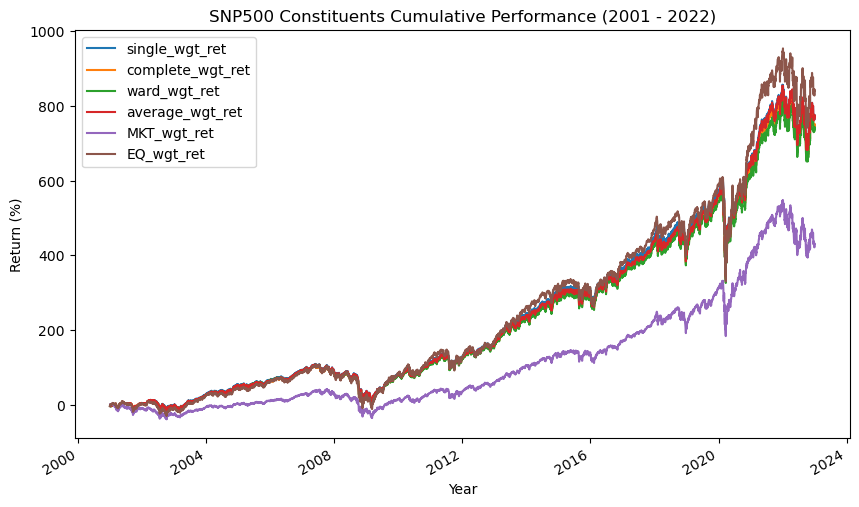

In [204]:
cum_ret_df.plot(figsize=(10,6))
plt.title("SNP500 Constituents Cumulative Performance (2001 - 2022)")
plt.xlabel("Year")
plt.ylabel("Return (%)")
plt.show()